/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9824756723113014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824756723113014
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9824756723113014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9824756723113014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9888
[LightGBM] [Info] Number of data points in the train set: 23471, number of used features: 8
[LightGBM] [Info] Start training from score 4.066045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

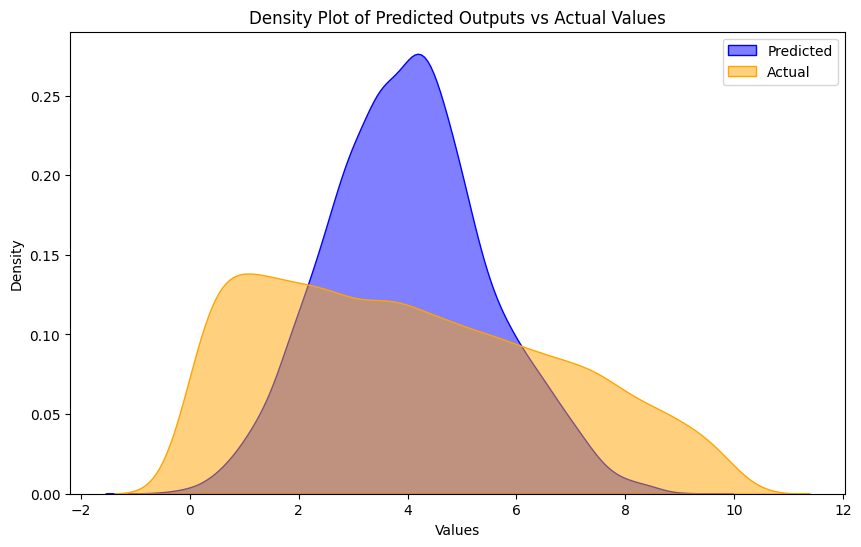

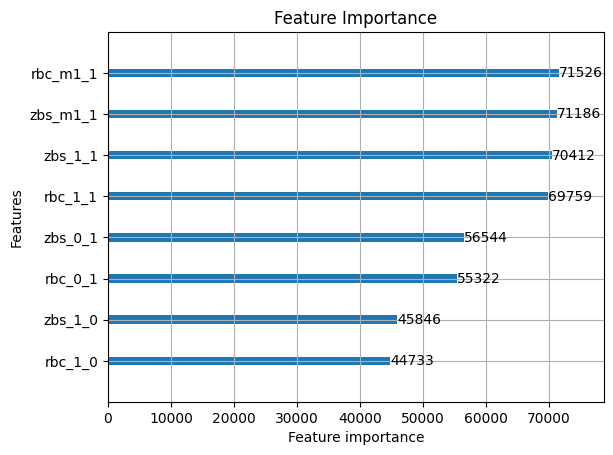

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the true positive predictions from the CSV file
true_positive_predictions_file = 'true_positive_predictions_with_quasi.csv'
true_positive_data = pd.read_csv(true_positive_predictions_file)

# Separate features and target variable
X = true_positive_data[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = true_positive_data['quasisymmetry']

features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

#print('Best trial:', study.best_trial)
#print('Best value:', study.best_value)
#print('Best parameters:', study.best_params)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Assuming study.best_params already includes the best hyperparameters from your Optuna study for a regression problem
#model = lgb.LGBMRegressor(**study.best_params)

best_params_manual = {
    "boosting_type": "dart",
    "max_depth": 35,
    "num_leaves": 449,
    "min_data_in_leaf": 100,
    "feature_fraction": 0.9824756723113014,
    "learning_rate": 0.24479713555351562,
    "num_iterations": 2917,
    "data_sample_strategy": "bagging",
    "max_bins": 1236
}

# Create and train the LightGBM model with the manually defined best parameters
model = lgb.LGBMRegressor(**best_params_manual)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

# After fitting, you can use the model to predict or evaluate it further
# For example, to predict new values
predictions = model.predict(test_features_no_outliers)

mse = mean_squared_error(test_target_no_outliers, predictions)
mae = mean_absolute_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

df_predictions = pd.DataFrame({
    "Predicted": predictions.flatten(),  # Flatten in case the predictions are in a 2D array
    "Type": "Predicted"
})
df_actual = pd.DataFrame({
    "Predicted": np.tile(test_target_no_outliers, (len(predictions) // len(test_target_no_outliers))),
    "Type": "Actual"
})

import matplotlib.pyplot as plt
import seaborn as sns

for i in range(len(predictions)):
    if predictions[i] < 0:
        print(f"Predicted: {predictions[i]}, Actual: {test_target_no_outliers.iloc[i]}")

# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(10, 6))
sns.kdeplot(predictions, fill=True, color="blue", alpha=0.5, label="Predicted")
sns.kdeplot(test_target_no_outliers, fill=True, color="orange", alpha=0.5, label="Actual")
plt.title('Density Plot of Predicted Outputs vs Actual Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

lgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()



/tmp/ipykernel_3979/2536432694.py:3: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(predictions), bins=50, alpha=0.5, label='Actual')


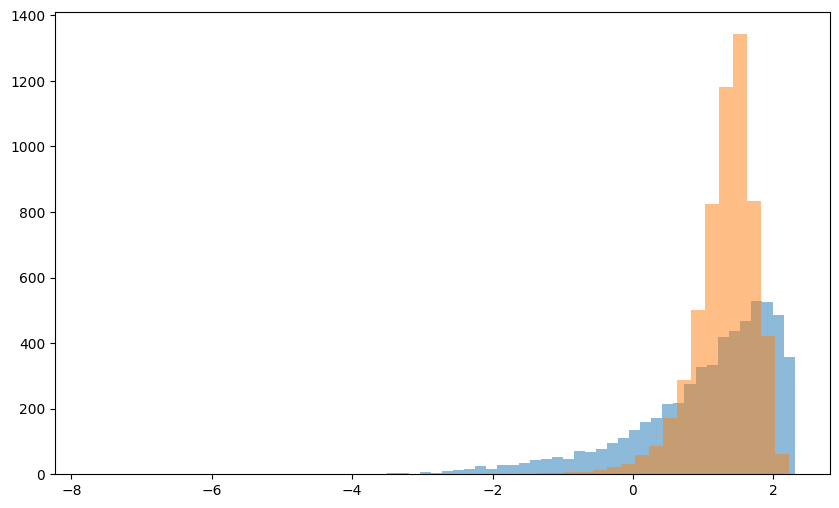

In [2]:
plt.figure(figsize=(10, 6)) 
plt.hist(np.log(test_target_no_outliers), bins=50, alpha=0.5, label='Predicted')
plt.hist(np.log(predictions), bins=50, alpha=0.5, label='Actual')
plt.show()


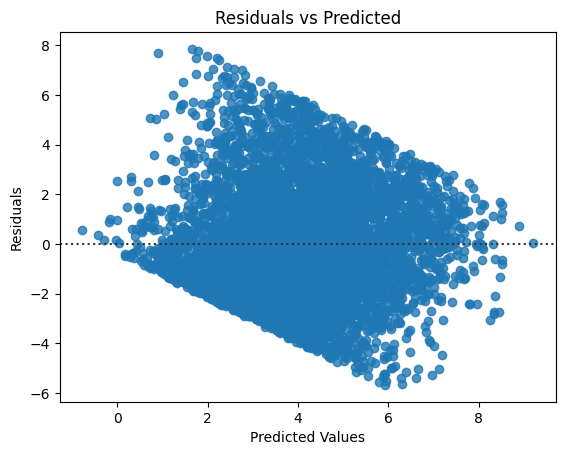

In [5]:
import seaborn as sns

residuals = test_target_no_outliers - predictions
sns.residplot(x=predictions, y=residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


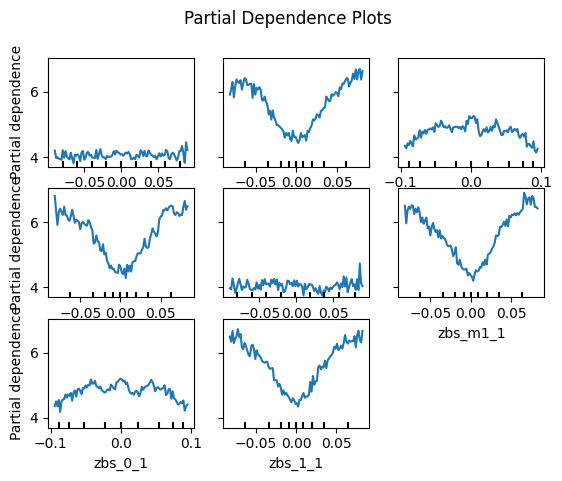

In [7]:
from sklearn.inspection import PartialDependenceDisplay


features = ['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']  # Adjust with your feature names
PartialDependenceDisplay.from_estimator(model, features_no_outliers, features)
plt.suptitle('Partial Dependence Plots')
plt.show()


ImportError: You must install graphviz and restart your session to plot tree.

<Figure size 2000x1000 with 0 Axes>

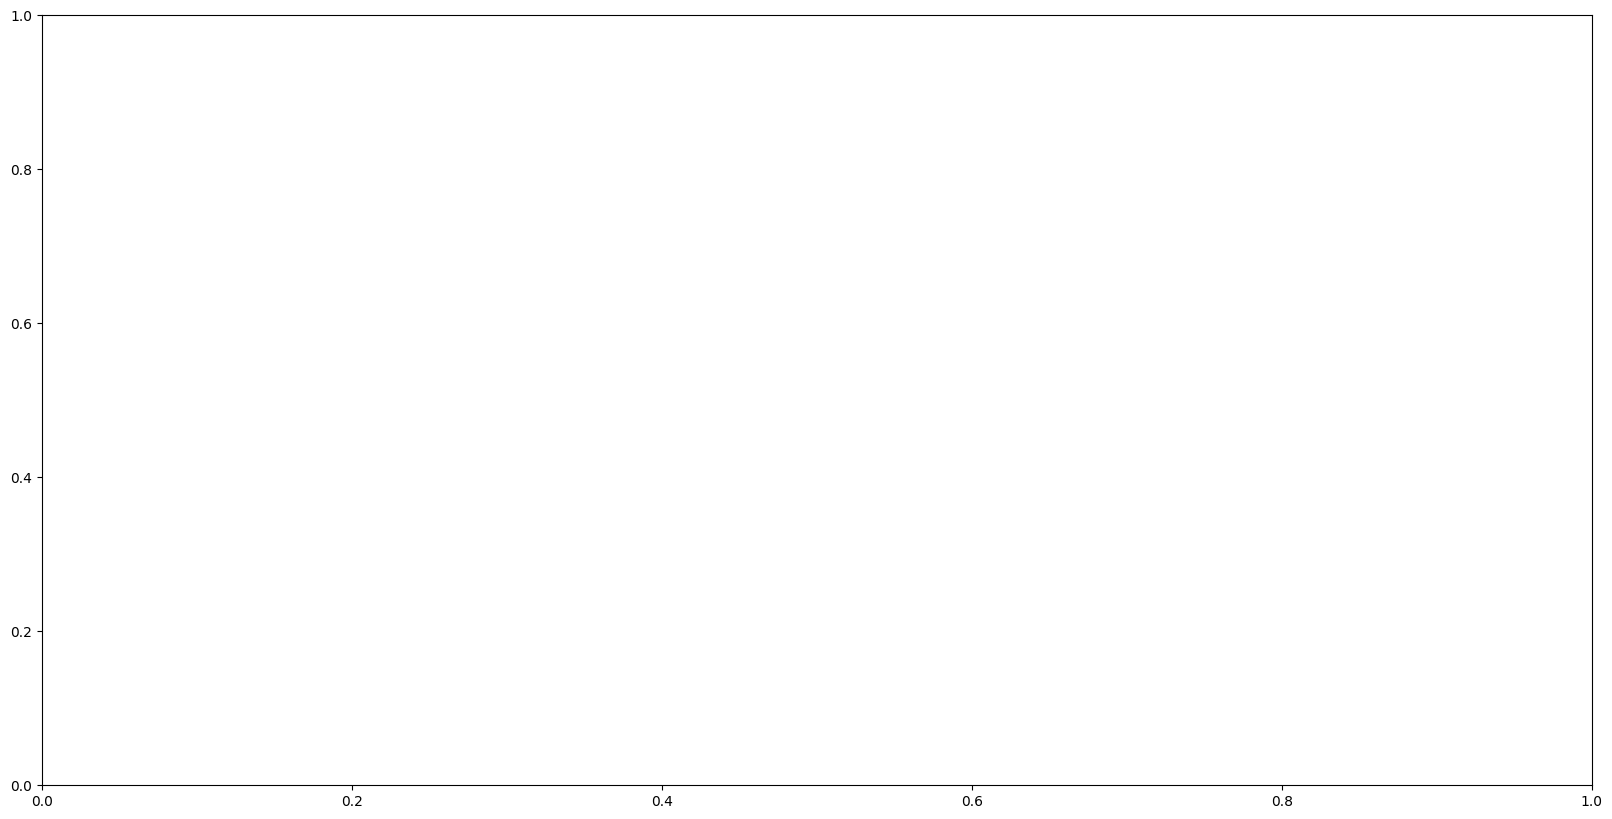

In [3]:
plt.figure(figsize=(20, 10))
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.title('Tree Plot')
plt.show()

In [ ]:
feature = 'zbs_m1_1' # Replace with your feature name if different
plt.figure(figsize=(10, 5))
ax = lgb.plot_split_value_histogram(model, feature=feature, figsize=(10, 5))
plt.title(f'Split Value Histogram for {feature}')
plt.show()

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting of candidate distributions completed: 100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


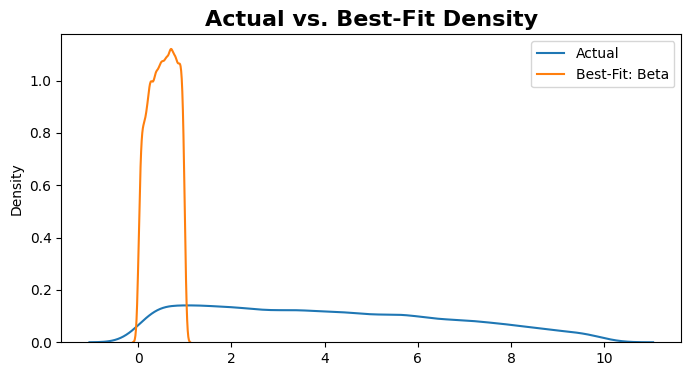

                nll      distribution
rank                                 
1        -24.950453              Beta
2       2826.197750            ZABeta
3      51691.402344         Expectile
4      54286.578673           Weibull
5      54808.518404  NegativeBinomial
6      54832.011705              ZINB
6      54832.011705              ZINB
8      54931.066406             Gamma
9      54954.550781           ZAGamma
10     55422.043972            Gumbel
11     55904.993578          Gaussian
12     55914.520898          StudentT
13     57002.665879           Poisson
14     58345.897631         LogNormal
15     58369.380369              ZALN
16     58458.710684           Laplace
17     61985.911710            Cauchy
18    284278.931047        SplineFlow


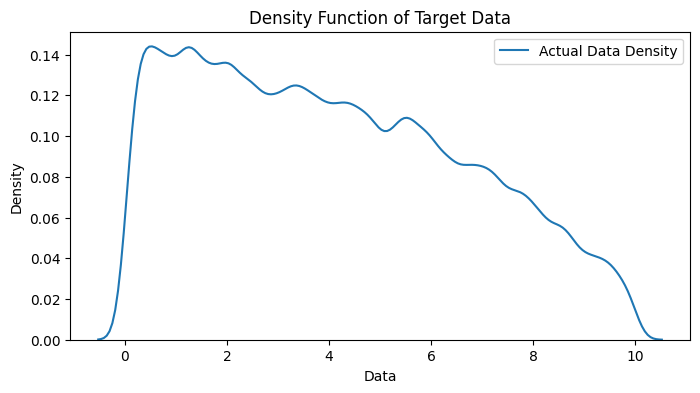

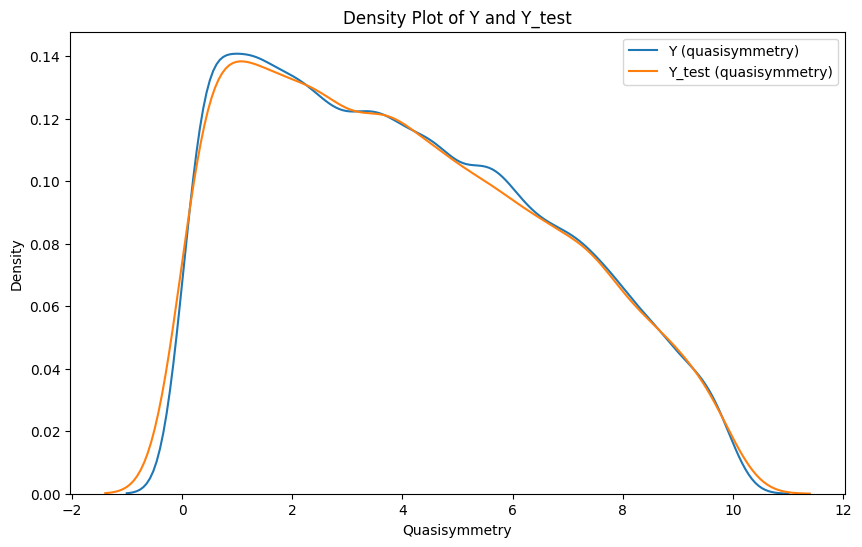

  0%|          | 0/1 [00:21<?, ?it/s]


[W 2024-05-30 01:31:48,556] Trial 0 failed with parameters: {'max_depth': 18, 'num_leaves': 5, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.967985545750277, 'min_sum_hessian_in_leaf': 7.548764540205035, 'feature_fraction': 0.5961745220871226, 'boosting_type': 'dart', 'learning_rate': 0.13123181482690746, 'max_delta_step': 0.3431780161508694, 'num_boost_round': 231, 'feature_pre_filter': False, 'boosting': 'gbdt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbmlss/model.py", line 387, in objective
    lgblss_param_tuning = self.cv(hyper_params,
  File "/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/lightgbmlss/model.py", line 269, in cv
    self.bstLSS_cv = lgb.cv(params,
  File "/home/r

KeyboardInterrupt: 

In [3]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np


# Load the true positive predictions from the CSV file
true_positive_predictions_file = 'true_positive_predictions_with_quasi.csv'
true_positive_data = pd.read_csv(true_positive_predictions_file)

# Separate features and target variable
X = true_positive_data[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = true_positive_data['quasisymmetry']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

target_no_outliers_np = np.array(Y_train)

# Initialize DistributionClass
lgblss_dist_class = DistributionClass()

# Define candidate distributions
candidate_distributions = [Beta, Cauchy, Expectile, Gamma, Gaussian, Gumbel, Laplace, LogNormal, NegativeBinomial, Poisson, SplineFlow, StudentT, Weibull, ZABeta, ZAGamma, ZALN, ZINB, ZINB]


# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=target_no_outliers_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
print(dist_nll)

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(target_no_outliers_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot the distribution of Y and Y_test
plt.figure(figsize=(10, 6))
sns.kdeplot(Y, label='Y (quasisymmetry)')
sns.kdeplot(Y_test, label='Y_test (quasisymmetry)')
plt.title('Density Plot of Y and Y_test')
plt.xlabel('Quasisymmetry')
plt.ylabel('Density')
plt.legend()
plt.show()


from lightgbmlss.model import LightGBMLSS
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np

# Select the first 1000 samples from X_train and their corresponding labels
X_train_subset = X_train
Y_train_subset = Y_train

# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(X_train_subset, label=Y_train_subset.values, params={'max_bin': 500})

# Initialize the LightGBMLSS model with the Weibull distribution
lgblss = LightGBMLSS(
    Weibull(stabilization="L2", response_fn="exp", loss_fn="nll")
)

# Define the parameter dictionary without max_bin
param_dict = {
    "max_depth": ["int", {"low": 1, "high": 25, "log": False}],
    "num_leaves": ["int", {"low": 2, "high": 100, "log": True}],
    "min_data_in_leaf": ["int", {"low": 20, "high": 500, "log": False}],
    "min_gain_to_split": ["float", {"low": 0.01, "high": 40, "log": True}],
    "min_sum_hessian_in_leaf": ["float", {"low": 0.01, "high": 100, "log": True}],
    #"subsample": ["float", {"low": 0.5, "high": 1.0, "log": False}],
    #"subsample_freq": ["int", {"low": 1, "high": 20, "log": False}],
    "feature_fraction": ["float", {"low": 0.3, "high": 1.0, "log": False}],
    "boosting_type": ["categorical", ["dart", "goss", "gbdt"]],
    "learning_rate": ["float", {"low": 0.1, "high": 0.2, "log": True}],
    # "lambda_l1" and "lambda_l2" are commented out as before
    "max_delta_step": ["float", {"low": 0, "high": 1, "log": False}],
    "num_boost_round": ["int", {"low": 5, "high": 1000, "log": True}],
    "feature_pre_filter": ["categorical", [False]],
}

# Set a seed for reproducibility
np.random.seed(123)

# Perform hyperparameter optimization
opt_param = lgblss.hyper_opt(
    param_dict,
    dtrain,
    #num_boost_round=30,
    nfold=5,
    early_stopping_rounds=50,
    max_minutes=403,
    n_trials=1,
    silence=True,
    seed=13,
    hp_seed=123
)

import numpy as np
import torch
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

# Seed for reproducibility in numpy operations
np.random.seed(123)

# Assuming opt_param is defined somewhere in your code
opt_params = opt_param.copy()
n_rounds = opt_params['num_boost_round']
del opt_params['num_boost_round']

print('ewfre', opt_params)
print('nu, boost', n_rounds)

# Assuming dtrain is defined and is an appropriate dataset for training
# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = len(X_test)  # Use the number of rows in X_test as the number of samples

# Sample from predicted distribution
pred_samples = lgblss.predict(
    X_test,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

# Return predicted distributional parameters
pred_params = lgblss.predict(
    X_test,
    pred_type="parameters"
)


